<a href="https://colab.research.google.com/github/Jvient/OSSE_BoB-4DVarNet/blob/main/Copie_de_GENN_Dec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init 

In [ ]:
#Import data 
from tqdm import tqdm
import numpy as np
import time
from sklearn.decomposition import PCA
from tqdm import tqdm
from random import randrange
import sklearn
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.sparse import diags
from scipy.stats import multivariate_normal
from scipy.ndimage.morphology import distance_transform_edt as bwdist
import scipy.ndimage as nd
from scipy.interpolate import RegularGridInterpolator
import tensorflow as tf
import keras
import scipy.stats as ss 
from keras.constraints import Constraint
from keras import backend as K
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Mounted at /content/drive
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 427707905535309961
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12360450352194424782
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


# Parameters 

In [ ]:
DirSAVE                     = '/'
flagTrWMissingData          = 1  # Training phase with or without missing data
flagloadOIData              = 0    # load OI: work on rough variable or anomaly
lname_cov                   = ["ssh_mod"]
lid_cov                     = ["OI"]
size_tw                     = 1   # Length of the 4th dimension          
Wsquare                     = 4     # half-width of holes
Nsquare                     = 3     # number of holes
DimAE                       = 20  # Dimension of the latent space
flagLoadModel               = 0     # load pre-defined AE model or not
sigNoise                    = 1e-1
flagTrOuputWOMissingData    = 1
stdMask                     = 0.
dropout                     = 0 #[0.6,0.7,0.8]0.03
wl2                         = 0.0000
batch_size                  = 16# monter un peu 
NbEpoc                      = 6
Niter                       = 6*3
thrMisData                  = 0
N_cov                       = 0
flagUseMaskinEncoder        = 1

def createGlobParams(params):
    return dict(((k, eval(k)) for k in params))
list_globParams=[
    'flagTrOuputWOMissingData','flagTrWMissingData',\
    'flagloadOIData','size_tw','Wsquare',\
    'Nsquare','DimAE','flagLoadModel',\
    'sigNoise',\
    'stdMask',\
    'dropout','wl2','batch_size',\
    'NbEpoc','Niter','DirSAVE','N_cov']
globParams = createGlobParams(list_globParams)

# Import data

In [ ]:
dataset= np.load("/content/drive/My Drive/DATA/Thèse/ZOI/Dataset_64_ZOI.npy",allow_pickle='TRUE').item()
dataH=dataset['CSED_Hourly']
mask=dataset['Cloud_Daily']
lat_grid=dataset['Lat_ZOI']
lon_grid=dataset['Lon_ZOI']
#corr lalpaciens var exp des norm
# =============================================================================
# Creation of the test and training dataset
# =============================================================================
def prepdata(xH,mask,N_Catalog=0):
    if N_Catalog!=0:
        test=np.zeros(mask[-365:].shape)
        for i in range(0,len(test)):
            test[i]=xH[26304+i*24+12].reshape(test.shape[1],test.shape[2])

        train=np.zeros((N_Catalog*365,xH.shape[1],xH.shape[2]))

        for i in range(N_Catalog):
            for j in range(len(test)):
                h=randrange(0,24)
                train[i*365+j]=xH[i*365+j*24+h]
    else:
        xD=np.empty((xH.shape[0]//24,xH.shape[1],xH.shape[2]))
        for i in range(len(xD)):
            xD[i]=xH[12+i*24]
    mask_train = mask[:-360]
    mask_pred  = mask[-360:]
    x_train    = xD[:len(mask_train)]
    #y_pred     = xD[len(mask_train)-100:len(mask_train)]
    y_pred     = xD[len(mask_train):len(mask_train)+len(mask_pred)]
    return mask_train,mask_pred,x_train,y_pred


mask[np.where(mask==0)]=1;mask[np.where(np.isnan(mask))]=0 # O for missing data
mask_train,mask_pred,x_train,y_pred = prepdata(dataH,mask)

x_train,x_test,mask_train,mask_test=sklearn.model_selection.train_test_split(x_train,mask_train,test_size=0.33)
# list of test dates
indN_Tt = np.arange(len(x_train),len(x_train)+len(x_test))
indN_Tr = np.arange(len(x_train))
lday_test=[ datetime.strftime(datetime.strptime("2001-1-01",'%Y-%m-%d')\
                      + timedelta(days=np.float64(i)),"%Y-%m-%d") for i in indN_Tt ]
indLat     = np.arange(0,64)
indLon     = np.arange(0,64)      
print(indLat.shape,indLon.shape,indN_Tr.shape,indN_Tt.shape)
print(x_train.shape,x_test.shape,y_pred.shape)

(64,) (64,) (720,) (356,)
(720, 64, 64) (356, 64, 64) (360, 64, 64)


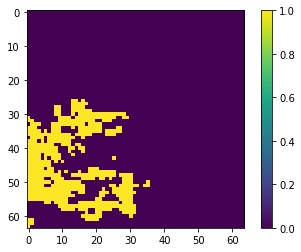

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(mask_pred[7].reshape(64,64))
plt.colorbar()

In [ ]:
gt_train= x_train
gt_test = x_test
gt_pred = np.copy(y_pred)
err_train = np.random.normal(0,thrMisData*np.nanvar(x_train),(x_train.shape))
err_test = np.random.normal(0,thrMisData*np.nanvar(x_test),(x_test.shape))
err_pred = np.random.normal(0,thrMisData*np.nanvar(y_pred),(y_pred.shape))

stdsc=sklearn.preprocessing.StandardScaler()
stdsc.fit(y_pred.reshape(y_pred.shape[0],-1))
mean_Tr = stdsc.mean_
medabs  = np.copy(mean_Tr)
med     = np.copy(mean_Tr)

for i in range(len(medabs)):
  med[i]    =np.nanmedian(gt_train.reshape(gt_train.shape[0],-1)[:,i])
  medabs[i] =np.nanmedian(np.absolute(gt_train.reshape(gt_train.shape[0],-1)[:,i]-med[i]))
  

print('MEAN',mean_Tr.shape)
std_Tr = stdsc.var_

gt_train        = gt_train.reshape(x_train.shape[0],-1)-mean_Tr
x_train         = x_train.reshape(x_train.shape[0],-1)-mean_Tr
#x_train_missing = stdsc.fit_transform(x_train_missing.reshape(x_train_missing.shape[0],-1))
gt_test         = gt_test.reshape(len(x_test),-1)-mean_Tr                       
x_test          = x_test.reshape(len(x_test),-1)-mean_Tr
#x_test_missing  = stdsc.fit_transform(x_test_missing.reshape(x_test_missing.shape[0],-1))
#y_pred_missing  = stdsc.fit_transform(y_pred_missing.reshape(len(y_pred),-1))
y_pred          = y_pred.reshape(len(y_pred),-1)-mean_Tr
#gt_pred         = stdsc.fit_transform(gt_pred.reshape(len(y_pred),-1))

if flagTrWMissingData == 1 :
    x_train_missing=x_train.reshape(x_train.shape[0],indLat.shape[0],indLon.shape[0])*mask_train
else :
    mask_train[np.where(~np.isnan(x_train))]=1
    x_train_missing=x_train.reshape(x_train.shape[0],indLat.shape[0],indLon.shape[0])*mask_train

x_test_missing=x_test.reshape(x_test.shape[0],indLat.shape[0],indLon.shape[0])*mask_test
if flagPred:
  mask_pred[15:,:,:] = 0
y_pred_missing=y_pred.reshape(y_pred.shape[0],indLat.shape[0],indLon.shape[0])*mask_pred

#Dimensionning                           
gt_train        = gt_train.reshape(x_train.shape[0],indLat.shape[0],indLon.shape[0],1)
x_train         = x_train.reshape(x_train.shape[0],indLat.shape[0],indLon.shape[0],1)
x_train_missing = x_train_missing.reshape(x_train_missing.shape[0],indLat.shape[0],indLon.shape[0],1)
mask_train      = mask_train.reshape(x_train.shape[0],indLat.shape[0],indLon.shape[0],1)

gt_test         = gt_test.reshape(indN_Tt.shape[0],indLat.shape[0],indLon.shape[0],1)
x_test          = x_test.reshape(indN_Tt.shape[0],indLat.shape[0],indLon.shape[0],1)
x_test_missing  = x_test_missing.reshape(indN_Tt.shape[0],indLat.shape[0],indLon.shape[0],1)   
mask_test       = mask_test.reshape(indN_Tt.shape[0],indLat.shape[0],indLon.shape[0],1)

#gt_pred         = gt_pred.reshape(y_pred.shape[0],indLat.shape[0],indLon.shape[0],1)
y_pred          = y_pred.reshape(y_pred.shape[0],indLat.shape[0],indLon.shape[0],1)
y_pred_missing  = y_pred_missing.reshape(y_pred_missing.shape[0],indLat.shape[0],indLon.shape[0],1)
mask_pred       = mask_pred.reshape(mask_pred.shape[0],indLat.shape[0],indLon.shape[0],1)

#Change Nan to 0 Check isany Nan/inf 
def isany(x):
    x[np.where(np.isnan(x))]=0
    print(np.any(np.isnan(x)))
    print(np.any(np.isinf(x)))
    print(x.shape)

isany(x_train)
isany(x_test)
isany(x_train_missing)
isany(x_test_missing)
isany(mask_test)
isany(mask_train)
isany(y_pred)
isany(y_pred_missing)
isany(x_train)
isany(gt_test)
isany(gt_train)
#isany(gt_pred)


print("... (after normalization) mean Tr = %f"%(np.mean(gt_train)))
print("... (after normalization) mean Tt = %f"%(np.mean(gt_test)))
#print("... (after normalization) mean Pred = %f"%(np.mean(gt_pred)))
print("... (after normalization) mean x_train = %f"%(np.mean(x_train)))
print("... (after normalization) mean x_train_missing = %f"%(np.mean(x_train_missing)))
print("... (after normalization) mean x_test = %f"%(np.mean(x_test)))
print("... (after normalization) mean x_test_missing = %f"%(np.mean(x_test_missing)))
print("... (after normalization) mean y_pred = %f"%(np.mean(y_pred)))
print("... (after normalization) mean y_pred_missing = %f"%(np.mean(y_pred_missing)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


MEAN (4096,)


IndexError: ignored

### Define GENN

In [ ]:
# Constraints on kernel to to zeros
# a specific position
class Constraint_Zero(Constraint):
    def __init__(self, position,kernel_shape,dw):
        self.position = position
        mask_array    = np.ones((kernel_shape))
        mask_array[position[0]-dw:position[0]+dw+1,position[1]-dw:position[1]+dw+1,:,:] = 0.0

        self.mask = K.variable(value=mask_array, dtype='float32', name='mask')

        print(self.mask.shape)
    def __call__(self, w):
        print(self.mask.shape)
        new_w = w * self.mask

        return new_w

def fl27(dict_global_Params,x_data,mask_data):

    # import Global Parameters
    for key,val in dict_global_Params.items():
        exec("globals()['"+key+"']=val")

    WFilter       = 11#
    NbResUnit     = 10#3#
    dW            = 0
    flagdownScale = 1 #: 0: only HR scale, 1 : only LR, 2 : HR + LR , 2 : MR, HR + LR annd LR,
    scaleLR       = 2**2
    NbFilter      = 1*DimAE
    flagSRResNet  = 0
     
    input_layer = keras.layers.Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
    mask       = keras.layers.Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
    
    if flagUseMaskinEncoder == 1:
        dmask   = keras.layers.Lambda(lambda x: 0.2*x - 0.1)(mask)
        
        for jj in range(0,6):
            dx    = keras.layers.Conv2D(10,(3,3),activation='relu', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(dmask)            
            dx    = keras.layers.Conv2D(1,(3,3),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(dx)            
            dmask = keras.layers.Add()([dmask,dx])
            
        x0       = keras.layers.Concatenate(axis=-1)([input_layer,dmask])
    else:
        x0  = keras.layers.Lambda(lambda x: 1. * x)(input_layer)

    # coarse scale
    if flagdownScale > 0 :
        if flagUseMaskinEncoder == 1:
            x = keras.layers.AveragePooling2D((scaleLR,scaleLR), padding='valid')(x0)
            
            x = keras.layers.Conv2D(NbFilter,(WFilter,WFilter),activation='relu', 
                padding='same',use_bias=False,
                kernel_regularizer=keras.regularizers.l2(wl2),
                kernel_constraint=Constraint_Zero((int(WFilter/2),int(WFilter/2)),(WFilter,WFilter,2*x_train.shape[3],NbFilter),dW))(x)
        else:
            x = keras.layers.AveragePooling2D((scaleLR,scaleLR), padding='valid')(x0)

            x = keras.layers.Conv2D(NbFilter,(WFilter,WFilter),activation='relu', 
            padding='same',use_bias=False,
            kernel_regularizer=keras.regularizers.l2(wl2),
            kernel_constraint=Constraint_Zero((int(WFilter/2),int(WFilter/2)),(WFilter,WFilter,x_train.shape[3],NbFilter),dW))(x)
        x  = keras.layers.Conv2D(DimAE,(1,1),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(x)
  
        # registration/evolution in feature space
        scale = 0.1
        for kk in range(0,NbResUnit):
            if 1*1 :
                dx = keras.layers.Conv2D(5*DimAE,(1,1),activation='relu', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(x)
            else:
                dx = keras.layers.Lambda(lambda x: scale * x)(x)
      
            dx_lin  = keras.layers.Conv2D(DimAE,(1,1),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(dx)
            dx1 = keras.layers.Conv2D(DimAE,(1,1),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(dx)
            dx2 = keras.layers.Conv2D(DimAE,(1,1),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(dx)
      
            dx1 = keras.layers.Multiply()([dx1,dx2])
            
            dx  = keras.layers.Add()([dx1,dx_lin])
            dx  = keras.layers.Activation('tanh')(dx)
            x  = keras.layers.Add()([x,dx])
        x  = keras.layers.Conv2D(int(x_train.shape[3]/(N_cov+1)),(1,1),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(x)
        x1 = keras.layers.Conv2DTranspose(int(x_train.shape[3]/(N_cov+1)),(scaleLR,scaleLR),strides=(scaleLR,scaleLR),use_bias=False,activation='linear',padding='same',output_padding=None,kernel_regularizer=keras.regularizers.l2(wl2))(x)
        
        if flagSRResNet == 1: ## postprocessing: super-resolution-like block
            x1  = keras.layers.Conv2D(DimAE,(3,3),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(x1)               
            
            scale = 0.1
            for kk in range(0,NbResUnit):
                if 1*1 :
                    dx = keras.layers.Conv2D(2*DimAE,(3,3),activation='relu', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(x1)
                else:
                    dx = keras.layers.Lambda(lambda x: scale * x)(x1)
          
                dx_lin  = keras.layers.Conv2D(DimAE,(3,3),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(dx)
                dx1 = keras.layers.Conv2D(DimAE,(3,3),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(dx)
                dx2 = keras.layers.Conv2D(DimAE,(3,3),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(dx)
          
                dx1 = keras.layers.Multiply()([dx1,dx2])
        
                dx  = keras.layers.Add()([dx1,dx_lin])
                dx  = keras.layers.Activation('tanh')(dx_lin)
                x1  = keras.layers.Add()([x1,dx])
            x1  = keras.layers.Conv2D(x_train.shape[3]/(N_cov+1),(3,3),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(x1)
        else:
            x1  = keras.layers.Conv2D(2*DimAE,(3,3),activation='relu', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(x1) 
            x1  = keras.layers.Conv2D(int(x_train.shape[3]/(N_cov+1)),(3,3),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(x1)          
     
    # fine scale
    if flagUseMaskinEncoder == 1:
        x = keras.layers.Conv2D(NbFilter,(WFilter,WFilter),activation='relu', 
            padding='same',use_bias=False,
            kernel_regularizer=keras.regularizers.l2(wl2),
            kernel_constraint=Constraint_Zero((int(WFilter/2),int(WFilter/2)),(WFilter,WFilter,2*x_train.shape[3],NbFilter),dW))(x0)
    else:
        x = keras.layers.Conv2D(NbFilter,(WFilter,WFilter),activation='relu', 
            padding='same',use_bias=False,
            kernel_regularizer=keras.regularizers.l2(wl2),
            kernel_constraint=Constraint_Zero((int(WFilter/2),int(WFilter/2)),(WFilter,WFilter,x_train.shape[3],NbFilter),dW))(x0)

    if flagdownScale > 0 :
        x  = keras.layers.Concatenate(axis=-1)([x,x1])
    x  = keras.layers.Conv2D(DimAE,(1,1),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(x)

    for kk in range(0,NbResUnit):
        if 1*1 :
            dx      = keras.layers.Conv2D(5*DimAE,(1,1),activation='relu', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(x)
        else:
            dx  = keras.layers.Lambda(lambda x: scale * x)(x)
          
        dx_lin  = keras.layers.Conv2D(DimAE,(1,1),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(dx)
        dx1 = keras.layers.Conv2D(DimAE,(1,1),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(dx)
        dx2 = keras.layers.Conv2D(DimAE,(1,1),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(dx)
          
        dx1 = keras.layers.Multiply()([dx1,dx2])
        
        dx  = keras.layers.Add()([dx1,dx_lin])
        dx  = keras.layers.Activation('tanh')(dx)
        x  = keras.layers.Add()([x,dx])

    x  = keras.layers.Conv2D(int(x_train.shape[3]/(N_cov+1)),(1,1),activation='linear', padding='same',use_bias=False,kernel_regularizer=keras.regularizers.l2(wl2))(x)

    if flagdownScale == 0:
        encoder    = keras.models.Model([input_layer,mask],x)
    elif flagdownScale == 1:
        encoder    = keras.models.Model([input_layer,mask],x1)
    elif flagdownScale == 2:
        x          = keras.layers.Add()([x,x1]) 
        encoder    = keras.models.Model([input_layer,mask],x)
    elif flagdownScale == 3:
        x          = keras.layers.Add()([x,x1]) 
        encoder    = keras.models.Model([input_layer,mask],[x1,x])
   
    if flagdownScale == 3:
        decoder_input1 = keras.layers.Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))    
        decoder_input2 = keras.layers.Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))    
        x1  = keras.layers.Lambda(lambda x: 1. * x)(decoder_input1)
        x2  = keras.layers.Lambda(lambda x: 1. * x)(decoder_input2)
        decoder       = keras.models.Model([decoder_input1,decoder_input2],[x1,x2])
    else:
        decoder_input = keras.layers.Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))    
        x  = keras.layers.Lambda(lambda x: 1. * x)(decoder_input)
        decoder       = keras.models.Model(decoder_input,x)
      
    encoder.summary()
    decoder.summary()

    if flagdownScale < 3:
        input_data = keras.layers.Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
        mask       = keras.layers.Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
  
        x          = decoder(encoder([input_data,mask]))
        model_AE   = keras.models.Model([input_data,mask],x)      
    elif flagdownScale == 3:
        
        input_data = keras.layers.Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
        mask       = keras.layers.Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
        x,xLR      = encoder([input_data,mask])
        
        model_AE    = keras.models.Model([input_data,mask],x)
        model_AE_MR = keras.models.Model([input_data,mask],[x,xLR])

    size_tw = int(x_train.shape[3]/(N_cov+1))
    #model_AE.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(lr=1e-3))
    model_AE.compile(loss=keras_custom_loss_function(size_tw),optimizer=keras.optimizers.Adam(lr=1e-3))
    model_AE.summary()

    DimCAE = DimAE

    return encoder, decoder, model_AE, DimCAE

In [ ]:
def define_DINConvAE(NiterProjection,model_AE,shape,\
                    size_tw,N_cov=0):
                     

    # encoder-decoder with masked data
    x_input         = keras.layers.Input((shape[1],shape[2],shape[3]))
    mask            = keras.layers.Input((shape[1],shape[2],shape[3]))
    
    x     = keras.layers.Lambda(lambda x:1.*x)(x_input)
    mask_ = keras.layers.Lambda(lambda x:1.-x)(mask)

    # Iterations of fixed-point projection
    index = np.arange(0,(N_cov+1)*size_tw,N_cov+1)   
    for kk in range(0,NiterProjection):
        x_proj   = model_AE([x,mask])
        x_proj   = keras.layers.Multiply()([x_proj,slice_layer(index)(mask_)])
        x        = keras.layers.Multiply()([slice_layer(index)(x),slice_layer(index)(mask)])
        x        = keras.layers.Add()([x,x_proj])

    x_proj = model_AE([x,mask]) 
    global_model_FP    = keras.models.Model([x_input,mask],[x_proj])

    x_input         = keras.layers.Input((shape[1],shape[2],shape[3]))
    mask            = keras.layers.Input((shape[1],shape[2],shape[3]))

    maskg = keras.layers.Lambda(lambda x: 1.*x)(mask)
      
    x_proj = global_model_FP([x_input,maskg])

  
    # AE error with x_proj
    err1 = error(x_proj,x_input,mask,size_tw,shape,1,N_cov)
    # compute error (x_proj-x_input)**2 with full-1 mask
    x_proj2 = model_AE([x_proj,keras.layers.Lambda(lambda x:1.-0.*x)(mask)])
    err2    = error(x_proj,x_proj2,mask,size_tw,shape,0,N_cov)
    # compute error (x_proj-x_input)**2 with full-1 mask
    x_proj3 = model_AE([x_proj,keras.layers.Lambda(lambda x:0.*x)(mask)])
    err3    = error(x_proj3,x_proj,mask,size_tw,shape,0,N_cov)
    # add all errors
    err    = keras.layers.Add()([err1,err2])
    err    = keras.layers.Add()([err,err3])

    # return global model
    global_model_FP_Masked  = keras.models.Model([x_input,mask],err)
    global_model_FP.summary()
    global_model_FP_Masked.summary()
  
    return global_model_FP,global_model_FP_Masked

def slice_layer(index):
    def func(x_input):
        return tf.gather(x_input, index, axis=3)
    return keras.layers.Lambda(func)

def assign_sliced_layer(size_tw,N_cov,x_output):
    def func(x_input,x_output):
        for i in range(1,(N_cov+1)):
            index = np.arange(i,(N_cov+1)*size_tw,(N_cov+1),dtype='int32')
            x_output = keras.layers.Concatenate()([x_output,slice_layer(index)(x_input)])
        index  = np.stack([np.arange(i*size_tw,(i+1)*size_tw) \
                           for i in range(0,N_cov+1)]).T.flatten()
        x_proj = slice_layer(index)(x_output)
        return x_proj
    return keras.layers.Lambda(func,arguments={'x_output':x_output})

def error(x1,x2,mask,size_tw,shape,alpha,N_cov):
    if x1.shape[3]>x2.shape[3]:
        index = np.arange(0,(N_cov+1)*size_tw,N_cov+1,dtype='int32')
        err   = keras.layers.Subtract()([slice_layer(index)(x1),x2])
        err   = keras.layers.Multiply()([err,slice_layer(index)(mask)])
    elif x2.shape[3]>x1.shape[3]:
        index = np.arange(0,(N_cov+1)*size_tw,N_cov+1,dtype='int32')
        err   = keras.layers.Subtract()([x1,slice_layer(index)(x2)])
        err   = keras.layers.Multiply()([err,slice_layer(index)(mask)])
    else:
        err   = keras.layers.Subtract()([x1,x2])
        err   = keras.layers.Multiply()([err,mask])
    err   = keras.layers.Multiply()([err,err])
    err   = keras.layers.Reshape((err.shape[-3],err.shape[-2],err.shape[-1],1))(err)
    err   = keras.layers.GlobalAveragePooling3D()(err)
    err   = keras.layers.Reshape((1,))(err)
    err   = keras.layers.Lambda(lambda x: alpha*x)(err)
    return err

def keras_custom_loss_function(size_tw):
    def insert_Sobel(size_tw,dir="x"):
        kernel_weights=np.zeros((3,3,size_tw,size_tw))
        if dir=="x":
            sobel=np.array([[-1,0,1],[-2,0,2],[-1,0,1]]).T
        if dir=="y":
            sobel=np.array([[-1,-2,-1],[0,0,0],[1,2,1]]).T
        for i in range(size_tw):
            kernel_weights[:,:,i,i]=sobel
        return kernel_weights
    def lossFunction(y_true,y_pred):
        mae = tf.keras.losses.mean_absolute_error(y_true, y_pred)
        filter_gx  = K.constant(insert_Sobel(size_tw,"x"))
        filter_gy  = K.constant(insert_Sobel(size_tw,"y"))
        Gx_true = K.conv2d(y_true, filter_gx, padding="same")
        Gy_true = K.conv2d(y_true, filter_gy, padding="same")
        Grad_true = K.sqrt(keras.layers.Add()([keras.layers.Multiply()([Gx_true,Gx_true]),\
                                       keras.layers.Multiply()([Gy_true,Gy_true])]))
        Gx_pred = K.conv2d(y_pred, filter_gx, padding="same")
        Gy_pred = K.conv2d(y_pred, filter_gy, padding="same")
        Grad_pred = K.sqrt(keras.layers.Add()([keras.layers.Multiply()([Gx_pred,Gx_pred]),\
                                       keras.layers.Multiply()([Gy_pred,Gy_pred])]))
        mae_grad = tf.keras.losses.mean_absolute_error(Grad_true, Grad_pred)
        alpha= 0.5
        loss = ((1.-alpha)*mae) + (alpha*mae_grad)
        return loss
    return lossFunction

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

def eval_AEPerformance(x_train,rec_AE_Tr,x_test,rec_AE_Tt):

    mse_AE_Tr        = np.mean( (rec_AE_Tr - x_train)**2 )
    var_Tr           = np.mean( (x_train-np.mean(x_train,axis=0)) ** 2 )
    exp_var_AE_Tr    = 1. - mse_AE_Tr / var_Tr
   
    mse_AE_Tt        = np.mean( (rec_AE_Tt - x_test)**2 )
    var_Tt           = np.mean( (x_test-np.mean(x_train,axis=0))** 2 )
    exp_var_AE_Tt    = 1. - mse_AE_Tt / var_Tt
           
    return exp_var_AE_Tr,exp_var_AE_Tt

# functions for the evaluation of interpolation and auto-encoding performance
def eval_AEPerformance(x_train,rec_AE_Tr,x_test,rec_AE_Tt):

    mse_AE_Tr        = np.mean( (rec_AE_Tr - x_train)**2 )
    var_Tr           = np.mean( (x_train-np.mean(x_train,axis=0)) ** 2 )
    exp_var_AE_Tr    = 1. - mse_AE_Tr / var_Tr
    
    mse_AE_Tt        = np.mean( (rec_AE_Tt - x_test)**2 )
    var_Tt           = np.mean( (x_test-np.mean(x_train,axis=0))** 2 )
    exp_var_AE_Tt    = 1. - mse_AE_Tt / var_Tt
            
    return exp_var_AE_Tr,exp_var_AE_Tt

def eval_InterpPerformance(mask_train,x_train,x_train_missing,x_train_pred,
                           mask_test,x_test,x_test_missing,x_test_pred):
    mse_train      = np.zeros((2))
    mse_train[0]   = np.sum( mask_train * (x_train_pred - x_train_missing)**2 ) / np.sum( mask_train )
    mse_train[1]   = np.mean( (x_train_pred - x_train)**2 )
    exp_var_train  = 1. - mse_train #/ var_Tr
            
    mse_test        = np.zeros((2))
    mse_test[0]     = np.sum( mask_test * (x_test_pred - x_test_missing)**2 ) / np.sum( mask_test )
    mse_test[1]     = np.mean( (x_test_pred - x_test)**2 ) 
    exp_var_test = 1. - mse_test #/ var_Tt

    mse_train_interp        = np.sum( (1.-mask_train) * (x_train_pred - x_train)**2 ) / np.sum( 1. - mask_train )
    exp_var_train_interp    = 1. - mse_train_interp 
    
    mse_test_interp        = np.sum( (1.-mask_test) * (x_test_pred - x_test)**2 ) / np.sum( 1. - mask_test )
    exp_var_test_interp    = 1. - mse_test_interp
            
    return mse_train,exp_var_train,mse_test,exp_var_test,mse_train_interp,exp_var_train_interp,mse_test_interp,exp_var_test_interp

# function to create recursive paths
def mk_dir_recursive(dir_path):
    if os.path.isdir(dir_path):
        return
    h, t = os.path.split(dir_path)  # head/tail
    if not os.path.isdir(h):
        mk_dir_recursive(h)

    new_path = join_paths(h, t)
    if not os.path.isdir(new_path):
        os.mkdir(new_path)

def Gradient(img, order):
    """ calculate x, y gradient and magnitude """ 
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
    sobelx = sobelx/8.0
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
    sobely = sobely/8.0
    sobel_norm = np.sqrt(sobelx*sobelx+sobely*sobely)
    if (order==0):
        return sobelx
    elif (order==1):
        return sobely
    else:
        return sobel_norm

def insert_Sobel(size_tw,dir="x"):
    kernel_weights=np.zeros((3,3,size_tw,size_tw))
    if dir=="x":
        sobel=np.array([[-1,0,1],[-2,0,2],[-1,0,1]]).T
    if dir=="y":
        sobel=np.array([[-1,-2,-1],[0,0,0],[1,2,1]]).T
    for i in range(size_tw):
        kernel_weights[:,:,i,i]=sobel
    return kernel_weights

# New loss function for unsupervised setting:
# L = MAE + ||Grad||^2
def keras_custom_loss_function2(size_tw):
    def insert_Sobel(size_tw,dir="x"):
        kernel_weights=np.zeros((3,3,size_tw,size_tw))
        if dir=="x":
            sobel=np.array([[-1,0,1],[-2,0,2],[-1,0,1]]).T
        if dir=="y":
            sobel=np.array([[-1,-2,-1],[0,0,0],[1,2,1]]).T
        for i in range(size_tw):
            kernel_weights[:,:,i,i]=sobel
        return kernel_weights
    def lossFunction(y_true,y_pred):
        filter_gx  = K.constant(insert_Sobel(size_tw,"x"))
        filter_gy  = K.constant(insert_Sobel(size_tw,"y"))
        Gx_pred = K.conv2d(y_pred, filter_gx, padding="same")
        Gy_pred = K.conv2d(y_pred, filter_gy, padding="same")
        Grad_pred = K.sqrt(keras.layers.Add()([keras.layers.Multiply()([Gx_pred,Gx_pred]),\
                                       keras.layers.Multiply()([Gy_pred,Gy_pred])]))
        loss = K.mean(keras.layers.Multiply()([Grad_pred,Grad_pred]))
        return loss
    return lossFunction

def thresholding(x,thr):
    greater = K.greater_equal(x,thr) #will return boolean values
    greater = K.cast(greater, dtype=K.floatx()) #will convert bool to 0 and 1    
    return greater

def slice_layer(index):
    def func(x_input):
        return tf.gather(x_input, index, axis=3)
    return keras.layers.Lambda(func)

def assign_sliced_layer(size_tw,N_cov,x_output):
    def func(x_input,x_output):
        for i in range(1,(N_cov+1)):
            index = np.arange(i,(N_cov+1)*size_tw,(N_cov+1),dtype='int32')
            x_output = keras.layers.Concatenate()([x_output,slice_layer(index)(x_input)])
        index  = np.stack([np.arange(i*size_tw,(i+1)*size_tw) \
                           for i in range(0,N_cov+1)]).T.flatten()
        x_proj = slice_layer(index)(x_output)
        return x_proj
    return keras.layers.Lambda(func,arguments={'x_output':x_output})

def error(x1,x2,mask,size_tw,shape,alpha,N_cov):
    if x1.shape[3]>x2.shape[3]:
        index = np.arange(0,(N_cov+1)*size_tw,N_cov+1,dtype='int32')
        err   = keras.layers.Subtract()([slice_layer(index)(x1),x2])
        err   = keras.layers.Multiply()([err,slice_layer(index)(mask)])
    elif x2.shape[3]>x1.shape[3]:
        index = np.arange(0,(N_cov+1)*size_tw,N_cov+1,dtype='int32')
        err   = keras.layers.Subtract()([x1,slice_layer(index)(x2)])
        err   = keras.layers.Multiply()([err,slice_layer(index)(mask)])
    else:
        err   = keras.layers.Subtract()([x1,x2])
        err   = keras.layers.Multiply()([err,mask])
    err   = keras.layers.Multiply()([err,err])
    err   = keras.layers.Reshape((err.shape[-3],err.shape[-2],err.shape[-1],1))(err)
    # normalize err
    err   = keras.layers.GlobalAveragePooling3D()(err)
    err   = keras.layers.Reshape((1,))(err)
    err   = keras.layers.Lambda(lambda x: alpha*x)(err)
    return err

def regularize_Gradient(x_proj,size_tw):
    filter_gx  = K.constant(insert_Sobel(size_tw,"x"))
    filter_gy  = K.constant(insert_Sobel(size_tw,"y"))
    def Gradient(tensors):
        tensor = tensors[0]
        filter = tensors[1]
        return K.conv2d(tensor, filter, padding="same")
    Gx_pred = keras.layers.Lambda(Gradient)([x_proj, filter_gx])
    Gy_pred = keras.layers.Lambda(Gradient)([x_proj, filter_gy])
    #Grad_pred = K.sqrt(keras.layers.Add()([keras.layers.Multiply()([Gx_pred,Gx_pred]),\
    #                                    keras.layers.Multiply()([Gy_pred,Gy_pred])]))
    Grad_pred = keras.layers.Add()([keras.layers.Multiply()([Gx_pred,Gx_pred]),\
                                        keras.layers.Multiply()([Gy_pred,Gy_pred])])
    reg_Gradient   = keras.layers.Reshape((Grad_pred.shape[-3],Grad_pred.shape[-2],Grad_pred.shape[-1],1))(Grad_pred)
    reg_Gradient   = keras.layers.GlobalAveragePooling3D()(reg_Gradient)
    reg_Gradient   = keras.layers.Reshape((1,))(reg_Gradient)
    reg_Gradient   = keras.layers.Lambda(lambda x: 1*x)(reg_Gradient)
    return reg_Gradient

def define_DINConvAE(NiterProjection,model_AE,shape,\
                     flagUseMaskinEncoder,\
                     size_tw,include_covariates,N_cov=0):

    # encoder-decoder with masked data
    x_input         = keras.layers.Input((shape[1],shape[2],shape[3]))
    mask            = keras.layers.Input((shape[1],shape[2],shape[3]))
    
    x     = keras.layers.Lambda(lambda x:1.*x)(x_input)
    mask_ = keras.layers.Lambda(lambda x:1.-x)(mask)

    # Iterations of fixed-point projection
    index = np.arange(0,(N_cov+1)*size_tw,N_cov+1)   
    for kk in range(0,NiterProjection):
        x_proj   = model_AE([x,mask])
        x_proj   = keras.layers.Multiply()([x_proj,slice_layer(index)(mask_)])
        x        = keras.layers.Multiply()([slice_layer(index)(x),slice_layer(index)(mask)])
        x        = keras.layers.Add()([x,x_proj])


    x_proj = model_AE([x,mask]) 
    global_model_FP    = keras.models.Model([x_input,mask],[x_proj])

    # randomly sample an additionnal missing data mask
    # additive noise + spatial smoothing
    if flagUseMaskinEncoder == 1:
        WAvFilter     = 3
        NIterAvFilter = 3
        thrNoise      = 1.5 * stdMask + 1e-7
        maskg   = keras.layers.GaussianNoise(stdMask)(mask)
        avFilter       = 1./(WAvFilter**3)*np.ones((WAvFilter,WAvFilter,WAvFilter,1,1))
        spatialAvLayer = keras.layers.Conv3D(1,(WAvFilter,WAvFilter,WAvFilter),weights=[avFilter],\
                           padding='same',activation='linear',use_bias=False,name='SpatialAverage')
        spatialAvLayer.trainable = False
        maskg = keras.layers.Lambda(lambda x: K.permute_dimensions(x,(0,3,1,2)))(maskg) 
        maskg  = keras.layers.Reshape((shape[3],shape[1],shape[2],1))(maskg)
        for nn in range(0,NIterAvFilter):
            maskg  = spatialAvLayer(maskg) 
        maskg = keras.layers.Lambda(lambda x: K.permute_dimensions(x,(0,2,3,1,4)))(maskg) 
        maskg = keras.layers.Reshape((shape[1],shape[2],shape[3]))(maskg)
        maskg = keras.layers.Lambda(lambda x: thresholding(x,thrNoise))(maskg)    
        maskg  = keras.layers.Multiply()([mask,maskg])
        maskg  = keras.layers.Subtract()([mask,maskg])       
    else:
        maskg = keras.layers.Lambda(lambda x: 1.*x)(mask)

    x_proj = global_model_FP([x_input,maskg])
    # AE error with x_proj
    err1 = error(x_proj,x_input,mask,size_tw,shape,1,N_cov)
    # AE error with x_proj
    # compute error (x_proj-x_input)**2 with full-1 mask
    x_proj_ = x_proj
    
    x_proj2 = model_AE([x_proj_,keras.layers.Lambda(lambda x:1.-0.*x)(mask)])
    err2    = error(x_proj_,x_proj2,mask,size_tw,shape,0,N_cov)
    # compute error (x_proj-x_input)**2 with full-1 mask
    x_proj3 = model_AE([x_proj_,keras.layers.Lambda(lambda x:0.*x)(mask)])
    err3    = error(x_proj3,x_proj_,mask,size_tw,shape,0,N_cov)
    # add all errors
    err    = keras.layers.Add()([err1,err2])
    err    = keras.layers.Add()([err,err3])

    # return global model
    global_model_FP_Masked  = keras.models.Model([x_input,mask],[err,x_proj])

    global_model_FP.summary()
    global_model_FP_Masked.summary()
    return global_model_FP,global_model_FP_Masked

In [ ]:
#Apply model     
encoder, decoder, model_AE, DimCAE = fl27(globParams,x_train,mask_train)

(11, 11, 1, 20)
(11, 11, 1, 20)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 64, 64, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 16, 16, 1)    0           lambda[0][0]                     
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 20)   2420        average_pooling2d[0][0]          
______________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Train-Model - FP - Iterated projection

In [ ]:
def flagProcess4_Optim0(dict_global_Params,x_train,x_train_missing,mask_train,gt_train,\
                    x_test,x_test_missing,mask_test,gt_test,lday_test,encoder,decoder,model_AE,DimCAE):

    for key,val in dict_global_Params.items():
        exec("globals()['"+key+"']=val")

    meanTr = stdsc.mean_
    stdTr = np.mean(stdsc.var_)
    # ***************** #
    # model compilation #
    # ***************** #

    # model fit
    NbProjection   = [0,0,2,2,5,5,10,15,14]
    NbProjection   = [5,5,5,5]
    lrUpdate       = [1e-3,1e-4,1e-5,1e-5,1e-5,1e-6,1e-6,1e-5,1e-6]
    if flagTrOuputWOMissingData==0:
        lrUpdate   = [1e-4,1e-5,1e-6,1e-7]
    else:
        lrUpdate   = [1e-3,1e-4,1e-5,1e-6]
    IterUpdate     = [0,3,10,15,20,25,30,35,40]
    #IterUpdate     = [0,6,15,20]
    val_split      = 0.1
    
    iterInit = 0
    IterTrainAE = 0
    IterUpdateInit = 10000
    
    ## initialization
    x_train_init = np.copy(x_train_missing)
    x_test_init  = np.copy(x_test_missing)

    comptUpdate = 0

    # ******************** #
    # Start Learning model #
    # ******************** #
        
    print("..... Start learning AE model")
    for iter in tqdm(range(iterInit,Niter)):
        if iter == IterUpdate[comptUpdate]:
            # update DINConvAE model
            NBProjCurrent = NbProjection[comptUpdate]
            print("..... Update/initialize number of projections in DINCOnvAE model # %d"%(NbProjection[comptUpdate]))
            global_model_FP,global_model_FP_Masked = define_DINConvAE(NbProjection[comptUpdate],model_AE,x_train.shape,\
                                                                          flagUseMaskinEncoder,\
                                                                          size_tw,N_cov)
            if flagTrOuputWOMissingData == 1:
                #global_model_FP.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(lr=lrUpdate[comptUpdate]))
                global_model_FP.compile(loss=keras_custom_loss_function(size_tw),optimizer=keras.optimizers.Adam(lr=lrUpdate[comptUpdate]))
            else:
                global_model_FP_Masked.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(lr=lrUpdate[comptUpdate]))
                #global_model_FP_Masked.compile(loss=['mean_squared_error',keras_custom_loss_function2(size_tw)],loss_weights=[1.0,1e-10],optimizer=keras.optimizers.Adam(lr=lrUpdate[comptUpdate]))
            if comptUpdate < len(NbProjection)-1:
                comptUpdate += 1
        
        # gradient descent iteration            
        if flagTrOuputWOMissingData == 1:
            history = global_model_FP.fit([x_train_init,mask_train],gt_train,
                  batch_size=batch_size,
                  epochs = NbEpoc,
                  verbose = 1, 
                  validation_split=val_split)
        else:
            history = global_model_FP_Masked.fit([x_train_init,mask_train],[np.zeros((x_train_init.shape[0],1)),gt_train],
                  batch_size=batch_size,
                  epochs = NbEpoc,
                  verbose = 1, 
                  validation_split=val_split)

        # *********************** #
        # Prediction on test data #
        # *********************** #

        # trained full-model
        x_train_pred    = global_model_FP.predict([x_train_init,mask_train])
        x_test_pred     = global_model_FP.predict([x_test_init,mask_test])

        # trained AE applied to gap-free data
        if flagUseMaskinEncoder == 1:
          rec_AE_Tr     = model_AE.predict([x_train,np.zeros((mask_train.shape))])
          rec_AE_Tt     = model_AE.predict([x_test,np.zeros((mask_train.shape))])
        else:
          rec_AE_Tr     = model_AE.predict([x_train,np.ones((mask_train.shape))])
          rec_AE_Tt     = model_AE.predict([x_test,np.ones((mask_test.shape))])


        mse_train,exp_var_train,\
        mse_test,exp_var_test,\
        mse_train_interp,exp_var_train_interp,\
        mse_test_interp,exp_var_test_interp =\
        eval_InterpPerformance(mask_train,x_train,x_train_missing,x_train_pred,\
                               mask_test,x_test,x_test_missing,x_test_pred)
        
        # interpolation and reconstruction score for the center image
        # when dealing with time series
        if x_train_init.shape[3] > 0 :
            
            dWCenter    = 32  
            
            dT = np.floor( x_train_init.shape[3] / 2 ).astype(int)
            mse_train_center        = np.mean( (x_train_pred[:,:,:,dT] - x_train[:,:,:,dT] )**2 )
            mse_train_center_interp = np.sum( (x_train_pred[:,:,:,dT]  - x_train[:,:,:,dT] )**2 * (1.-mask_train[:,:,:,dT])  ) / np.sum( (1.-mask_train[:,:,:,dT]) )
            
            mse_test_center         = np.mean( (x_test_pred[:,:,:,dT] - x_test[:,:,:,dT] )**2 )
            mse_test_center_interp  = np.sum( (x_test_pred[:,:,:,dT]  - x_test[:,:,:,dT] )**2 * (1.-mask_test[:,:,:,dT])  ) / np.sum( (1-mask_test[:,:,:,dT]) )
            
            var_train_center        = np.var(  x_train[:,:,:,dT] )
            var_test_center         = np.var(  x_test[:,:,:,dT] )
            
            exp_var_train_center         = 1.0 - mse_train_center / var_train_center
            exp_var_train_interp_center  = 1.0 - mse_train_center_interp / var_train_center
            exp_var_test_center          = 1.0 - mse_test_center  / var_test_center
            exp_var_test_interp_center   = 1.0 - mse_test_center_interp/ var_test_center
        # AE performance of the trained AE applied to gap-free data
        exp_var_AE_Tr,exp_var_AE_Tt = eval_AEPerformance(x_train,rec_AE_Tr,x_test,rec_AE_Tt)
        
        print(".......... Auto-encoder performance when applied to gap-free data")
        print('.... explained variance AE (Tr)  : %.2f%%'%(100.*exp_var_AE_Tr))
        print('.... explained variance AE (Tt)  : %.2f%%'%(100.*exp_var_AE_Tt))
        
        if flagUseMaskinEncoder == 1:
        
            exp_var_AE_Tr,exp_var_AE_Tt = eval_AEPerformance(x_train,rec_AE_Tr,x_test,rec_AE_Tt)
        
            print('.... explained variance AE (Tr) with mask  : %.2f%%'%(100.*exp_var_AE_Tr))
            print('.... explained variance AE (Tt) with mask  : %.2f%%'%(100.*exp_var_AE_Tt))



        # update training data
        if iter > IterUpdateInit:
            # mask = 0(missing data) ; 1(data)
          x_train_init = mask_train * x_train_missing + (1.-mask_train) * x_train_pred
          x_test_init  = mask_test  * x_test_missing  + (1.-mask_test)  * x_test_pred
    return global_model_FP,global_model_FP_Masked
print('ready')



ready


In [ ]:
global_model_FP,global_model_FP_Masked=flagProcess4_Optim0(globParams,x_train,x_train_missing,mask_train,gt_train,x_test,x_test_missing,mask_test,gt_test,lday_test,encoder,decoder,model_AE,DimCAE)

  0%|          | 0/18 [00:00<?, ?it/s]

..... Start learning AE model
..... Update/initialize number of projections in DINCOnvAE model # 5
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 64, 64, 1)    0           input_6[0][0]                    
_____________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/6
(11, 11, 1, 20)
(11, 11, 1, 20)
41/41 [==============================] - 161s 3s/step - loss: 0.1566 - add_46_loss: 0.0043 - model_3_loss: 0.1523 - val_loss: 0.1306 - val_add_46_loss: 0.0026 - val_model_3_loss: 0.1280
Epoch 2/6
41/41 [==============================] - 89s 2s/step - loss: 0.1430 - add_46_loss: 0.0015 - model_3_loss: 0.1415 - val_loss: 0.1156 - val_add_46_loss: 0.0011 - val_model_3_loss: 0.1144
Epoch 3/6
41/41 [==============================] - 100s 2s/step - loss: 0.1176 - add_46_loss: 7.4288e-04 - model_3_loss: 0.1168 - val_loss: 0.1098 - val_add_46_loss: 9.0096e-04 - val_model_3_loss: 0.1089
Epoch 4/6
41/41 [==============================] - 109s 3s/step - loss: 0.1171 - add_46_loss: 5.6330e-04 - model_3_loss: 0.1165 - val_loss: 0.1089 - val_add_46_loss: 8.0988e-04 - val_model_3_loss: 0.1081
Epoch 5/6
41/41 [==============================] - 104s 3s/step - loss: 0.1194 - add_46_loss: 4.7985e-04 - model_3_loss: 0.1189 - val_loss: 0.1058 - val_add_46_loss: 8.0

  6%|▌         | 1/18 [11:59<3:23:56, 719.77s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 61.80%
.... explained variance AE (Tt)  : 63.85%
Epoch 1/6
41/41 [==============================] - 92s 2s/step - loss: 0.1182 - add_46_loss: 5.5913e-04 - model_3_loss: 0.1177 - val_loss: 0.1051 - val_add_46_loss: 7.2118e-04 - val_model_3_loss: 0.1044
Epoch 2/6
41/41 [==============================] - 94s 2s/step - loss: 0.1178 - add_46_loss: 5.5526e-04 - model_3_loss: 0.1173 - val_loss: 0.1047 - val_add_46_loss: 6.9292e-04 - val_model_3_loss: 0.1040
Epoch 3/6
41/41 [==============================] - 91s 2s/step - loss: 0.1171 - add_46_loss: 5.3478e-04 - model_3_loss: 0.1166 - val_loss: 0.1038 - val_add_46_loss: 6.8131e-04 - val_model_3_loss: 0.1031
Epoch 4/6
41/41 [==============================] - 97s 2s/step - loss: 0.1176 - add_46_loss: 5.4793e-04 - model_3_loss: 0.1171 - val_loss: 0.1046 - val_add_46_loss: 7.0657e-04 - val_model_3_loss: 0.1039
Epoch 5/6
41/41 [=====================

 11%|█         | 2/18 [22:56<3:06:54, 700.93s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 64.40%
.... explained variance AE (Tt)  : 66.28%
Epoch 1/6
41/41 [==============================] - 107s 3s/step - loss: 0.1160 - add_46_loss: 5.2233e-04 - model_3_loss: 0.1155 - val_loss: 0.1021 - val_add_46_loss: 6.4394e-04 - val_model_3_loss: 0.1015
Epoch 2/6
41/41 [==============================] - 100s 2s/step - loss: 0.1153 - add_46_loss: 5.0429e-04 - model_3_loss: 0.1148 - val_loss: 0.1019 - val_add_46_loss: 6.4424e-04 - val_model_3_loss: 0.1012
Epoch 3/6
41/41 [==============================] - 102s 2s/step - loss: 0.1153 - add_46_loss: 5.0144e-04 - model_3_loss: 0.1148 - val_loss: 0.1008 - val_add_46_loss: 6.2816e-04 - val_model_3_loss: 0.1002
Epoch 4/6
41/41 [==============================] - 97s 2s/step - loss: 0.1150 - add_46_loss: 4.9089e-04 - model_3_loss: 0.1145 - val_loss: 0.0999 - val_add_46_loss: 6.5785e-04 - val_model_3_loss: 0.0992
Epoch 5/6
41/41 [==================

 17%|█▋        | 3/18 [33:44<2:51:16, 685.12s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 66.19%
.... explained variance AE (Tt)  : 67.92%
..... Update/initialize number of projections in DINCOnvAE model # 5
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
lambda_25 (Lambda)              (None, 64, 64, 1)    0           input_8[0][0]                    
_______________________________________________________________________

 22%|██▏       | 4/18 [47:29<2:49:36, 726.86s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 66.72%
.... explained variance AE (Tt)  : 68.38%
Epoch 1/6
41/41 [==============================] - 100s 2s/step - loss: 0.1134 - add_53_loss: 4.7952e-04 - model_5_loss: 0.1129 - val_loss: 0.0990 - val_add_53_loss: 6.1692e-04 - val_model_5_loss: 0.0984
Epoch 2/6
41/41 [==============================] - 96s 2s/step - loss: 0.1134 - add_53_loss: 4.8021e-04 - model_5_loss: 0.1129 - val_loss: 0.0994 - val_add_53_loss: 6.1096e-04 - val_model_5_loss: 0.0987
Epoch 3/6
41/41 [==============================] - 99s 2s/step - loss: 0.1133 - add_53_loss: 4.7811e-04 - model_5_loss: 0.1128 - val_loss: 0.0991 - val_add_53_loss: 6.1196e-04 - val_model_5_loss: 0.0984
Epoch 4/6
41/41 [==============================] - 96s 2s/step - loss: 0.1133 - add_53_loss: 4.7812e-04 - model_5_loss: 0.1128 - val_loss: 0.0991 - val_add_53_loss: 6.1223e-04 - val_model_5_loss: 0.0985
Epoch 5/6
41/41 [====================

 28%|██▊       | 5/18 [58:17<2:32:24, 703.40s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 66.85%
.... explained variance AE (Tt)  : 68.49%
Epoch 1/6
41/41 [==============================] - 96s 2s/step - loss: 0.1132 - add_53_loss: 4.7730e-04 - model_5_loss: 0.1127 - val_loss: 0.0990 - val_add_53_loss: 6.1111e-04 - val_model_5_loss: 0.0984
Epoch 2/6
41/41 [==============================] - 97s 2s/step - loss: 0.1131 - add_53_loss: 4.7638e-04 - model_5_loss: 0.1127 - val_loss: 0.0988 - val_add_53_loss: 6.1188e-04 - val_model_5_loss: 0.0982
Epoch 3/6
41/41 [==============================] - 96s 2s/step - loss: 0.1132 - add_53_loss: 4.7864e-04 - model_5_loss: 0.1127 - val_loss: 0.0993 - val_add_53_loss: 6.0730e-04 - val_model_5_loss: 0.0987
Epoch 4/6
41/41 [==============================] - 98s 2s/step - loss: 0.1131 - add_53_loss: 4.7607e-04 - model_5_loss: 0.1126 - val_loss: 0.0987 - val_add_53_loss: 6.1090e-04 - val_model_5_loss: 0.0981
Epoch 5/6
41/41 [=====================

 33%|███▎      | 6/18 [1:09:14<2:17:52, 689.39s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 66.94%
.... explained variance AE (Tt)  : 68.57%
Epoch 1/6
41/41 [==============================] - 99s 2s/step - loss: 0.1130 - add_53_loss: 4.7486e-04 - model_5_loss: 0.1125 - val_loss: 0.0985 - val_add_53_loss: 6.1513e-04 - val_model_5_loss: 0.0979
Epoch 2/6
41/41 [==============================] - 97s 2s/step - loss: 0.1131 - add_53_loss: 4.7773e-04 - model_5_loss: 0.1126 - val_loss: 0.0989 - val_add_53_loss: 6.0700e-04 - val_model_5_loss: 0.0983
Epoch 3/6
41/41 [==============================] - 100s 2s/step - loss: 0.1130 - add_53_loss: 4.7503e-04 - model_5_loss: 0.1125 - val_loss: 0.0986 - val_add_53_loss: 6.0857e-04 - val_model_5_loss: 0.0980
Epoch 4/6
41/41 [==============================] - 100s 2s/step - loss: 0.1130 - add_53_loss: 4.7578e-04 - model_5_loss: 0.1125 - val_loss: 0.0988 - val_add_53_loss: 6.0569e-04 - val_model_5_loss: 0.0982
Epoch 5/6
41/41 [===================

 39%|███▉      | 7/18 [1:19:58<2:03:52, 675.72s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 67.02%
.... explained variance AE (Tt)  : 68.63%
Epoch 1/6
41/41 [==============================] - 101s 2s/step - loss: 0.1129 - add_53_loss: 4.7357e-04 - model_5_loss: 0.1124 - val_loss: 0.0985 - val_add_53_loss: 6.0786e-04 - val_model_5_loss: 0.0979
Epoch 2/6
41/41 [==============================] - 97s 2s/step - loss: 0.1129 - add_53_loss: 4.7408e-04 - model_5_loss: 0.1125 - val_loss: 0.0985 - val_add_53_loss: 6.0709e-04 - val_model_5_loss: 0.0979
Epoch 3/6
41/41 [==============================] - 97s 2s/step - loss: 0.1129 - add_53_loss: 4.7548e-04 - model_5_loss: 0.1124 - val_loss: 0.0987 - val_add_53_loss: 6.0525e-04 - val_model_5_loss: 0.0981
Epoch 4/6
41/41 [==============================] - 97s 2s/step - loss: 0.1128 - add_53_loss: 4.7297e-04 - model_5_loss: 0.1124 - val_loss: 0.0983 - val_add_53_loss: 6.0647e-04 - val_model_5_loss: 0.0977
Epoch 5/6
41/41 [====================

 44%|████▍     | 8/18 [1:30:46<1:51:15, 667.52s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 67.15%
.... explained variance AE (Tt)  : 68.75%
Epoch 1/6
41/41 [==============================] - 94s 2s/step - loss: 0.1128 - add_53_loss: 4.7284e-04 - model_5_loss: 0.1124 - val_loss: 0.0987 - val_add_53_loss: 6.0410e-04 - val_model_5_loss: 0.0981
Epoch 2/6
41/41 [==============================] - 98s 2s/step - loss: 0.1128 - add_53_loss: 4.7211e-04 - model_5_loss: 0.1124 - val_loss: 0.0982 - val_add_53_loss: 6.0714e-04 - val_model_5_loss: 0.0976
Epoch 3/6
41/41 [==============================] - 96s 2s/step - loss: 0.1127 - add_53_loss: 4.7282e-04 - model_5_loss: 0.1123 - val_loss: 0.0984 - val_add_53_loss: 6.0637e-04 - val_model_5_loss: 0.0978
Epoch 4/6
41/41 [==============================] - 98s 2s/step - loss: 0.1127 - add_53_loss: 4.7438e-04 - model_5_loss: 0.1122 - val_loss: 0.0988 - val_add_53_loss: 6.0339e-04 - val_model_5_loss: 0.0982
Epoch 5/6
41/41 [=====================

 50%|█████     | 9/18 [1:41:43<1:39:38, 664.27s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 67.08%
.... explained variance AE (Tt)  : 68.65%
Epoch 1/6
41/41 [==============================] - 101s 2s/step - loss: 0.1127 - add_53_loss: 4.7217e-04 - model_5_loss: 0.1122 - val_loss: 0.0984 - val_add_53_loss: 6.0419e-04 - val_model_5_loss: 0.0978
Epoch 2/6
41/41 [==============================] - 98s 2s/step - loss: 0.1127 - add_53_loss: 4.7150e-04 - model_5_loss: 0.1122 - val_loss: 0.0983 - val_add_53_loss: 6.0526e-04 - val_model_5_loss: 0.0977
Epoch 3/6
41/41 [==============================] - 106s 3s/step - loss: 0.1127 - add_53_loss: 4.7263e-04 - model_5_loss: 0.1122 - val_loss: 0.0984 - val_add_53_loss: 6.0475e-04 - val_model_5_loss: 0.0977
Epoch 4/6
41/41 [==============================] - 104s 3s/step - loss: 0.1126 - add_53_loss: 4.7103e-04 - model_5_loss: 0.1121 - val_loss: 0.0981 - val_add_53_loss: 6.0736e-04 - val_model_5_loss: 0.0975
Epoch 5/6
41/41 [==================

 56%|█████▌    | 10/18 [1:52:39<1:28:15, 661.93s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 67.13%
.... explained variance AE (Tt)  : 68.69%
..... Update/initialize number of projections in DINCOnvAE model # 5
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
lambda_48 (Lambda)              (None, 64, 64, 1)    0           input_10[0][0]                   
_______________________________________________________________________

 61%|██████    | 11/18 [2:02:46<1:15:16, 645.23s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 67.24%
.... explained variance AE (Tt)  : 68.81%
Epoch 1/6
41/41 [==============================] - 97s 2s/step - loss: 0.1125 - add_60_loss: 4.7126e-04 - model_7_loss: 0.1120 - val_loss: 0.0982 - val_add_60_loss: 6.0501e-04 - val_model_7_loss: 0.0976
Epoch 2/6
41/41 [==============================] - 98s 2s/step - loss: 0.1125 - add_60_loss: 4.7133e-04 - model_7_loss: 0.1120 - val_loss: 0.0982 - val_add_60_loss: 6.0514e-04 - val_model_7_loss: 0.0976
Epoch 3/6
41/41 [==============================] - 97s 2s/step - loss: 0.1125 - add_60_loss: 4.7124e-04 - model_7_loss: 0.1120 - val_loss: 0.0982 - val_add_60_loss: 6.0486e-04 - val_model_7_loss: 0.0976
Epoch 4/6
41/41 [==============================] - 97s 2s/step - loss: 0.1125 - add_60_loss: 4.7125e-04 - model_7_loss: 0.1120 - val_loss: 0.0982 - val_add_60_loss: 6.0501e-04 - val_model_7_loss: 0.0976
Epoch 5/6
41/41 [=====================

 67%|██████▋   | 12/18 [2:13:34<1:04:37, 646.18s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 67.23%
.... explained variance AE (Tt)  : 68.80%
Epoch 1/6
41/41 [==============================] - 94s 2s/step - loss: 0.1125 - add_60_loss: 4.7116e-04 - model_7_loss: 0.1120 - val_loss: 0.0982 - val_add_60_loss: 6.0474e-04 - val_model_7_loss: 0.0976
Epoch 2/6
41/41 [==============================] - 98s 2s/step - loss: 0.1124 - add_60_loss: 4.7104e-04 - model_7_loss: 0.1120 - val_loss: 0.0982 - val_add_60_loss: 6.0488e-04 - val_model_7_loss: 0.0976
Epoch 3/6
41/41 [==============================] - 114s 3s/step - loss: 0.1124 - add_60_loss: 4.7109e-04 - model_7_loss: 0.1120 - val_loss: 0.0982 - val_add_60_loss: 6.0466e-04 - val_model_7_loss: 0.0976
Epoch 4/6
41/41 [==============================] - 115s 3s/step - loss: 0.1124 - add_60_loss: 4.7103e-04 - model_7_loss: 0.1120 - val_loss: 0.0982 - val_add_60_loss: 6.0451e-04 - val_model_7_loss: 0.0976
Epoch 5/6
41/41 [===================

 72%|███████▏  | 13/18 [2:25:26<55:29, 665.93s/it]  

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 67.23%
.... explained variance AE (Tt)  : 68.80%
Epoch 1/6
41/41 [==============================] - 97s 2s/step - loss: 0.1124 - add_60_loss: 4.7125e-04 - model_7_loss: 0.1120 - val_loss: 0.0982 - val_add_60_loss: 6.0455e-04 - val_model_7_loss: 0.0976
Epoch 2/6
41/41 [==============================] - 96s 2s/step - loss: 0.1124 - add_60_loss: 4.7092e-04 - model_7_loss: 0.1120 - val_loss: 0.0982 - val_add_60_loss: 6.0460e-04 - val_model_7_loss: 0.0976
Epoch 3/6
41/41 [==============================] - 99s 2s/step - loss: 0.1124 - add_60_loss: 4.7103e-04 - model_7_loss: 0.1120 - val_loss: 0.0981 - val_add_60_loss: 6.0488e-04 - val_model_7_loss: 0.0975
Epoch 4/6
41/41 [==============================] - 117s 3s/step - loss: 0.1125 - add_60_loss: 4.7080e-04 - model_7_loss: 0.1120 - val_loss: 0.0982 - val_add_60_loss: 6.0424e-04 - val_model_7_loss: 0.0976
Epoch 5/6
41/41 [====================

 78%|███████▊  | 14/18 [2:37:11<45:09, 677.50s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 67.25%
.... explained variance AE (Tt)  : 68.82%
Epoch 1/6
41/41 [==============================] - 136s 3s/step - loss: 0.1124 - add_60_loss: 4.7112e-04 - model_7_loss: 0.1120 - val_loss: 0.0982 - val_add_60_loss: 6.0463e-04 - val_model_7_loss: 0.0976
Epoch 2/6
41/41 [==============================] - 139s 3s/step - loss: 0.1124 - add_60_loss: 4.7084e-04 - model_7_loss: 0.1120 - val_loss: 0.0982 - val_add_60_loss: 6.0431e-04 - val_model_7_loss: 0.0976
Epoch 3/6
41/41 [==============================] - 140s 3s/step - loss: 0.1124 - add_60_loss: 4.7083e-04 - model_7_loss: 0.1120 - val_loss: 0.0982 - val_add_60_loss: 6.0449e-04 - val_model_7_loss: 0.0976
Epoch 4/6
41/41 [==============================] - 136s 3s/step - loss: 0.1124 - add_60_loss: 4.7072e-04 - model_7_loss: 0.1120 - val_loss: 0.0982 - val_add_60_loss: 6.0417e-04 - val_model_7_loss: 0.0976
Epoch 5/6
41/41 [=================

 83%|████████▎ | 15/18 [2:52:00<37:02, 740.94s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 67.26%
.... explained variance AE (Tt)  : 68.83%
..... Update/initialize number of projections in DINCOnvAE model # 5
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
lambda_71 (Lambda)              (None, 64, 64, 1)    0           input_12[0][0]                   
_______________________________________________________________________

 89%|████████▉ | 16/18 [3:04:48<24:58, 749.15s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 67.26%
.... explained variance AE (Tt)  : 68.83%
Epoch 1/6
41/41 [==============================] - 117s 3s/step - loss: 0.1124 - add_67_loss: 4.7088e-04 - model_9_loss: 0.1119 - val_loss: 0.0981 - val_add_67_loss: 6.0454e-04 - val_model_9_loss: 0.0975
Epoch 2/6
41/41 [==============================] - 120s 3s/step - loss: 0.1124 - add_67_loss: 4.7088e-04 - model_9_loss: 0.1119 - val_loss: 0.0981 - val_add_67_loss: 6.0457e-04 - val_model_9_loss: 0.0975
Epoch 3/6
41/41 [==============================] - 118s 3s/step - loss: 0.1124 - add_67_loss: 4.7088e-04 - model_9_loss: 0.1119 - val_loss: 0.0981 - val_add_67_loss: 6.0456e-04 - val_model_9_loss: 0.0975
Epoch 4/6
41/41 [==============================] - 120s 3s/step - loss: 0.1124 - add_67_loss: 4.7085e-04 - model_9_loss: 0.1119 - val_loss: 0.0981 - val_add_67_loss: 6.0450e-04 - val_model_9_loss: 0.0975
Epoch 5/6
41/41 [=================

 94%|█████████▍| 17/18 [3:17:40<12:36, 756.13s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 67.26%
.... explained variance AE (Tt)  : 68.83%
Epoch 1/6
41/41 [==============================] - 101s 2s/step - loss: 0.1124 - add_67_loss: 4.7086e-04 - model_9_loss: 0.1119 - val_loss: 0.0981 - val_add_67_loss: 6.0453e-04 - val_model_9_loss: 0.0975
Epoch 2/6
41/41 [==============================] - 102s 2s/step - loss: 0.1124 - add_67_loss: 4.7087e-04 - model_9_loss: 0.1119 - val_loss: 0.0981 - val_add_67_loss: 6.0451e-04 - val_model_9_loss: 0.0975
Epoch 3/6
41/41 [==============================] - 101s 2s/step - loss: 0.1124 - add_67_loss: 4.7085e-04 - model_9_loss: 0.1119 - val_loss: 0.0981 - val_add_67_loss: 6.0452e-04 - val_model_9_loss: 0.0975
Epoch 4/6
41/41 [==============================] - 102s 2s/step - loss: 0.1124 - add_67_loss: 4.7086e-04 - model_9_loss: 0.1119 - val_loss: 0.0981 - val_add_67_loss: 6.0450e-04 - val_model_9_loss: 0.0975
Epoch 5/6
41/41 [=================

100%|██████████| 18/18 [3:28:33<00:00, 695.18s/it]

.......... Auto-encoder performance when applied to gap-free data
.... explained variance AE (Tr)  : 67.27%
.... explained variance AE (Tt)  : 68.83%


### Prédiction / Interpolation 

In [ ]:
Pred_GM = global_model_FP.predict([y_pred_missing,mask_pred]).reshape(gt_pred.shape[0],gt_pred.shape[1],gt_pred.shape[2])
Pred_AE = model_AE.predict([y_pred_missing,mask_pred]).reshape(gt_pred.shape[0],gt_pred.shape[1],gt_pred.shape[2])

#.reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])

In [ ]:
Pred_AE_norm = stdsc.inverse_transform(Pred_AE.reshape(len(y_pred),-1)).reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])
Pred_GM_norm = stdsc.inverse_transform(Pred_GM.reshape(len(y_pred),-1)).reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])
#Pred_GM = ((Pred_GM*std_Tr)+mean_Tr).reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])
#Pred_GM_msk_norm = stdsc.inverse_transform(Pred_GM_mask.reshape(len(y_pred),-1)).reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])

In [ ]:
Pred_AE_norm = (Pred_AE.reshape(len(y_pred),-1)+medabs) .reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])
Pred_GM_norm = (Pred_GM.reshape(len(y_pred),-1)+medabs).reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])

#Pred_GM = ((Pred_GM*std_Tr)+mean_Tr).reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])
#Pred_GM_msk_norm = stdsc.inverse_transform(Pred_GM_mask.reshape(len(y_pred),-1)).reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])

In [ ]:
Pred_AE_norm = (Pred_AE.reshape(len(y_pred),-1)+mean_Tr) .reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])
Pred_GM_norm = (Pred_GM.reshape(len(y_pred),-1)+mean_Tr).reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])

#Pred_GM = ((Pred_GM*std_Tr)+mean_Tr).reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])
#Pred_GM_msk_norm = stdsc.inverse_transform(Pred_GM_mask.reshape(len(y_pred),-1)).reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])

In [ ]:
print(Pred_GM_norm.shape)

(360, 64, 64)


In [ ]:
Pred_AE_norm[np.where(Pred_AE_norm>np.nanmax(gt_pred))]=np.nanmax(gt_pred)
Pred_GM_norm[np.where(Pred_GM_norm>np.nanmax(gt_pred))]=np.nanmax(gt_pred)
Pred_AE_norm[np.where(Pred_AE_norm<np.nanmin(gt_pred))]=np.nanmin(gt_pred)
Pred_GM_norm[np.where(Pred_GM_norm<np.nanmin(gt_pred))]=np.nanmin(gt_pred)

-1.4053140266074076 -1.7323652999268637 -0.5334281921386719
-4.0007500854553655 -4.000840831664391 -4.0


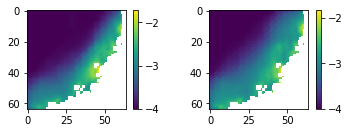

In [ ]:
i=0
plt.subplot(221)
plt.imshow(Pred_GM_norm.reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])[0])
plt.colorbar()
plt.subplot(222)
plt.imshow(Pred_GM_norm.reshape(Pred_GM_norm.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])[50])
plt.colorbar()

print(np.nanmax(Pred_GM_norm),np.nanmax(Pred_AE_norm),np.nanmax(gt_pred))
print(np.nanmin(Pred_GM_norm),np.nanmin(Pred_AE_norm),np.nanmin(gt_pred))

In [ ]:
plt.imshow()

In [ ]:
meantrue=np.empty(len(gt_pred))
meanpred=np.copy(meantrue)
for i in range(len(gt_pred)):
  meanpred[i]=np.nanmean(Pred_AE_norm[i])
  meantrue[i]=np.nanmean(gt_pred[i])
plt.plot(meanpred)
plt.plot(meantrue)

# Some metrics


In [ ]:
#from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
import datetime as dt
import matplotlib.pyplot as plt

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.nanmean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(a,b):
    """ Compute the Root Mean Square Error between 2 n-dimensional vectors. """ 
    return np.sqrt(np.nanmean((a-b)**2))


def Getmetrics(Target,Pred):
    Target_value = Target.reshape(Target.shape)[np.where(~np.isnan(Target))]
    Pred_value   = Pred.reshape(Target.shape)[np.where(~np.isnan(Target))]
    Target_flat  = Target_value.flatten()
    Pred_flat    = Pred_value.flatten()
    Metrics=dict()

    return {'EVS':explained_variance_score(Target_flat,Pred_flat),'RMSE':RMSE(Target_flat,Pred_flat),'NRMSE':RMSE(Target_flat,Pred_flat)/np.nanmean(Target_flat),'MAbsEr%':mean_absolute_percentage_error(Target_flat,Pred_flat),'MaxEr':max_error(Target_flat,Pred_flat),'MAbsEr':median_absolute_error(Target_flat,Pred_flat),'R²':r2_score(Target_flat,Pred_flat)}

   #lissage donnée entrée flatn + nan
#Metric=Getmetrics(stdsc.fit_transform(gt_pred.reshape(len(y_pred),-1)),Pred_GM )
testAE=np.copy(Pred_AE_norm)
testAE[np.where(testAE<np.nanmin(gt_pred))]=np.nanmin(gt_pred)
#print(np.nanmin(testAE))
MetricGM=Getmetrics(gt_pred,Pred_GM_norm)
MetricAE=Getmetrics(gt_pred,Pred_AE_norm)
print(MetricGM,MetricAE)
print(Getmetrics(gt_pred,testAE),Getmetrics(gt_pred,Pred_AE_norm),MetricGM)

{'EVS': 0.7327389851907187, 'RMSE': 0.28132012671795137, 'NRMSE': -0.07628929802424594, 'MAbsEr%': 5.355910060013508, 'MaxEr': 1.7077053272061877, 'MAbsEr': 0.08686242196207683, 'R²': 0.719328967552334} {'EVS': 0.6778243973825961, 'RMSE': 0.30193940823726484, 'NRMSE': -0.08188090119613645, 'MAbsEr%': 5.862410385339343, 'MaxEr': 1.7077053272061877, 'MAbsEr': 0.08514354877077279, 'R²': 0.6766777573140119}
{'EVS': 0.6778244019037626, 'RMSE': 0.30193940822706306, 'NRMSE': -0.0818809011933699, 'MAbsEr%': 5.862409503387738, 'MaxEr': 1.7077053272061877, 'MAbsEr': 0.08514354877077279, 'R²': 0.6766777573358604} {'EVS': 0.6778243973825961, 'RMSE': 0.30193940823726484, 'NRMSE': -0.08188090119613645, 'MAbsEr%': 5.862410385339343, 'MaxEr': 1.7077053272061877, 'MAbsEr': 0.08514354877077279, 'R²': 0.6766777573140119} {'EVS': 0.7327389851907187, 'RMSE': 0.28132012671795137, 'NRMSE': -0.07628929802424594, 'MAbsEr%': 5.355910060013508, 'MaxEr': 1.7077053272061877, 'MAbsEr': 0.08686242196207683, 'R²': 0.

In [ ]:
np.save('/content/drive/MyDrive/GENN_pred_normbestP00',testAE)
np.save('/content/drive/MyDrive/GENN_GM_norm200',Pred_GM_norm)

In [ ]:
global_model_FP.save("/content/drive/MyDrive/modelGENN1.h5")
model_AE.save("/content/drive/MyDrive/modelGENN.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
model.save("/content/drive/MyDrive/modelGENN.h5")
print("Saved model to disk")
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('modelGENN.h5')

NameError: ignored

In [ ]:
seriepred=[]
for i in range(len(y_pred)-45):
    seriepred.append(y_pred_missing[i:i+45])
SP=np.array(seriepred)
SP[:,15:,:,:]=np.nan
mask_sp=np.copy(SP)
mask_sp[np.where(np.isnan(mask_sp))]=0;mask_sp[np.where(mask_sp!=0)]=1


In [ ]:
y_sp_predAE=np.copy(SP.reshape(SP.shape[0],SP.shape[1],SP.shape[2],SP.shape[3]))
y_sp_predGM=np.copy(y_sp_predAE)
def predsp(y_pred,mask_pred):
    gt_pred=y_pred.reshape(y_pred.shape[0],y_pred.shape[1],y_pred.shape[2])

    Pred_GM = global_model_FP.predict([y_pred,mask_pred]).reshape(gt_pred.shape[0],gt_pred.shape[1],gt_pred.shape[2])
    Pred_AE = model_AE.predict([y_pred,mask_pred]).reshape(gt_pred.shape[0],gt_pred.shape[1],gt_pred.shape[2])

    Pred_AE_norm = (Pred_AE.reshape(len(y_pred),-1)+mean_Tr) .reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])
    Pred_GM_norm = (Pred_GM.reshape(len(y_pred),-1)+mean_Tr).reshape(Pred_AE.shape[0],Pred_AE.shape[1],Pred_AE.shape[2])
    return Pred_AE_norm,Pred_GM_norm

for i in range(len(SP)):
  y_sp_predAE[i], y_sp_predGM[i]=predsp(SP[i],mask_sp[i])
  

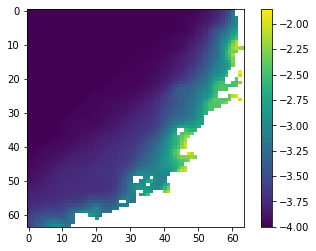

In [ ]:
plt.imshow(y_sp_predAE[50,30])
plt.colorbar()

In [ ]:
np.save('/content/drive/MyDrive/GENN_pred_SPAE',y_sp_predAE)
np.save('/content/drive/MyDrive/GENN_pred_SPGM',y_sp_predAE)

In [ ]:
flagPred = True
seriepred=[]
seriepredmask=[]
Tseriepred=[]
for i in range(len(y_pred)-45):
    seriepred.append(y_pred_missing[i:i+45])
    seriepredmask.append(mask_pred[i:i+45])
    Tseriepred.append(y_pred[i:i+45])
SP=np.array(seriepred)
SPm=np.array(seriepredmask)
TSP=np.array(Tseriepred)
del (seriepred,seriepredmask,Tseriepred)
TSP=(TSP.reshape(len(SP),SP.shape[1],-1)+mean_Tr).reshape(TSP.shape[0],TSP.shape[1],TSP.shape[2],TSP.shape[3])
if flagPred:
  SP[:,30:45]=np.nan
  SPm[:,30:45]=0
  
print(SP.shape)
Pred_GM_all = np.full((SP.shape[0],SP.shape[1],SP.shape[2],SP.shape[3]),np.nan)
Pred_AE_all = np.copy(Pred_GM_all)
for i in tqdm(range(len(SP))):
  Pred_GM_all[i] = global_model_FP.predict([SP[i],SPm[i]]).reshape(SP[i].shape[0],gt_pred.shape[1],gt_pred.shape[2])
  Pred_AE_all[i] = model_AE.predict([SP[i],SPm[i]]).reshape(SP[i].shape[0],gt_pred.shape[1],gt_pred.shape[2])

Pred_AE_all_norm = (Pred_AE_all.reshape(len(SP),SP.shape[1],-1)).reshape(SP.shape[0],SP.shape[1],SP.shape[2],SP.shape[3])
Pred_GM_all_norm = (Pred_GM_all.reshape(len(SP),SP.shape[1],-1)).reshape(SP.shape[0],SP.shape[1],SP.shape[2],SP.shape[3])

  0%|          | 0/315 [00:00<?, ?it/s]

(315, 45, 64, 64, 1)


100%|██████████| 315/315 [01:06<00:00,  4.75it/s]


In [ ]:
test=Pred_GM_all_norm[4,30:]-Pred_GM_all_norm[50,30:]
print(np.nanmin(test),np.nanmax(test))

0.0 0.0


100%|██████████| 315/315 [00:00<00:00, 998.69it/s]


(315,)


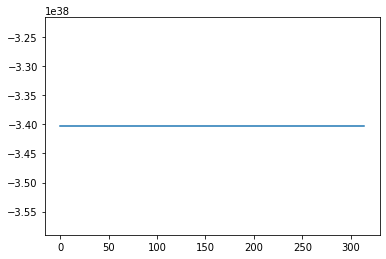

In [ ]:
meanGM=np.empty(len(Pred_GM_all_norm))
meanAE=np.empty(len(Pred_GM_all_norm))
meantarget= np.copy(meanGM)
for i in tqdm(range(len(Pred_GM_all_norm))):
  meanGM[i]=RMSE(Pred_GM_all_norm[i,30:],TSP[i,30:])
  meantarget[i]=np.nanmean(TSP[i,30:])
  meanAE[i]=np.nanmean(Pred_AE_all_norm[i,30:])
plt.plot(meanGM)
#plt.plot(meanAE)
#plt.plot(meantarget)
print(meantarget.shape)

In [ ]:
seriepredi=[]
for i in range(len(y_pred)-45):
    seriepredi.append(testAE[i:i+45])
SPui=np.array(seriepredi)

In [ ]:
np.save('/content/drive/MyDrive/Pred_GENN',Pred_GM_all_norm)